# Global Overturning Streamfunction

This scipt plots the global overturning streamfunction in density space for 3 ACCESS-OM2 simulations at different resolutions.

It also serves as a sample for how to compute and display diagnostics for the ACCESS-OM2 model evaluation paper.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg-iaf', '025deg-ryf', '01deg']


In [2]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 40015:127.0.0.1:40015 vdi-n13.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:34434 Dashboard: http://127.0.0.1:40015/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


**For starters**, list the three experiments you want to use. For now, we will use RYF sample runs - in the future we hope to be using the full interannual forcing simulations. This script assumes that there are 3 experiments, and that they are ordered as 1°, 0.25° then 0.1°.

This function computes the overturning from ty_trans_rho. 

**TO DO:** 
* Alter this to compute over a specific date range.
* Avoid use of filesPerYear

In [3]:
def calc_psi_avg(expt, n=4):
    
    ## Load overturning from ocean.nc file
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=n,
                          time_units = 'days since 1958-01-01')
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=n,
                              time_units = 'days since 1958-01-01')
        psiGM = psiGM.sum('grid_xt_ocean')*1.0e-9
    else:
        GM = False
        
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    if GM:
        psi_avg = psi_avg + psiGM.mean('time')
    
    ## This function basically splits the calculation up to save on memory:
    psi_avg = cc.compute_by_block(psi_avg)
    #psi_avg = psi_avg.compute()
    
    return psi_avg

Compute average overturning for each of the three simulations

In [ ]:
# 1° resolution 
ekey = '1deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)
psi_avg_1 = calc_psi_avg(expt,1)
IPython.display.clear_output()

1deg_jra55v13_iaf_spinup1_A


In [ ]:
# 0.25° resolution - 20 years
ekey = '025deg-iaf'
expt = exptdata.exptdict[ekey]['expt']
print(expt)
psi_avg_025 = calc_psi_avg(expt,10)
IPython.display.clear_output()

In [ ]:
# 0.1° resolution
# just 1 year for now, or it runs out of memory
ekey = '01deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)
psi_avg_01 = calc_psi_avg(expt,12)
IPython.display.clear_output()

This function plots the streamfunction.

In [ ]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.curl,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

And here is the code to make the actual figure.

In [ ]:
plt.figure(figsize=(13,4.5))
clev=np.arange(-25,25,2)
plt.subplot(131)
plot_psi(psi_avg_1,clev)
plt.title('(a) ACCESS-OM2')
plt.subplot(132)
p1 = plot_psi(psi_avg_025,clev)
plt.ylabel('')
plt.title('(b) ACCESS-OM2-025')
plt.subplot(133)
p1 = plot_psi(psi_avg_01,clev)
plt.ylabel('')
plt.title('(c) ACCESS-OM2-01')

plt.subplots_adjust(left=0.08,right=0.92)

ax1 = plt.axes([0.94,0.3,0.008,0.4])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Sv')

plt.savefig('mean_overturning.pdf')

Now compute timeseries of abyssal overturning

In [ ]:
%%time
# 1° resolution 
ekey = '1deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)

psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},time_units = 'days since 1958-01-01')
psi = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)
    
#print(psi.time)

psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None},time_units = 'days since 1958-01-01')
psiGM = psiGM.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)
#print(psiGM.time)

psi = psi*1.0e-9
psiGM = psiGM*1.0e-9

psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
psi_sum = psi_sum + psiGM

psi_aabw = psi_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
psi_aabw.plot(label=expt)


# 0.25° resolution 
ekey = '025deg-iaf'
expt = exptdata.exptdict[ekey]['expt']
print(expt)

psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},time_units = 'days since 1958-01-01')
psi = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)

psi = psi*1.0e-9

psi_sum = psi.cumsum('potrho') - psi.sum('potrho')

psi_aabw = psi_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
psi_aabw.plot(label=ekey)

plt.ylim(ymin=-28)
plt.legend()
plt.ylabel('Overturning (Sv)')
plt.xlabel('Year')
plt.title('Abyssal overturning at 40S')
plt.savefig('aabw_overturning_timeseries.pdf')

In [19]:
# 0.1° resolution 
ekey = '01deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)

psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},time_units = None)
psi = psi.sum('grid_xt_ocean').sel(method='Nearest', grid_yu_ocean=-40)

psi = psi*1.0e-9

psi_sum = psi.cumsum('potrho') - psi.sum('potrho')

psi_aabw = psi_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
psi_aabw.plot(label=expt)

plt.ylim(ymin=-28)
plt.legend()

01deg_jra55v13_ryf8485_spinup6


/home/157/amh157/cosima-cookbook/cosima_cookbook/netcdf_index.py:387: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

TypeError: Plotting requires coordinates to be numeric or dates of type np.datetime64 or datetime.datetime.

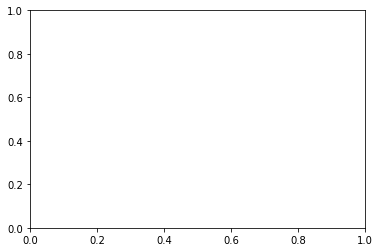

In [20]:
psi_aabw = psi_sum.sel(potrho=slice(1036,None)).min('potrho')
psi_aabw.plot(label=expt)

plt.ylim(ymin=-28)
plt.legend()